In [1]:
from tractseg.data import dataset_specific_utils
from tractseg.libs.AFQ_MultiCompCorrection import AFQ_MultiCompCorrection
from tractseg.libs.AFQ_MultiCompCorrection import get_significant_areas
from tractseg.libs import metric_utils
from tractseg.libs import tracking
from tractseg.libs import tractometry
from dipy.tracking.utils import length

import os
import argparse
import math
from decimal import Decimal
from os.path import join

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats
import pandas as pd
from tqdm import tqdm

import glob as glob
import nibabel as nib
from scipy.stats import t as t_dist
from tractseg.libs import plot_utils
from sklearn.linear_model import LinearRegression

/home/romain/.local/lib/python3.7/site-packages/dipy/stats/__init__.py:7: UserWarning: The `dipy.stats` module is still under heavy development and functionality, as well as the API is likely to change in future versions of the software
  warnings.warn(w_string)


In [29]:
STUDY_PATH='/NAS/deathrow/protocoles/MEDU_ST_PHI/'
IMAGES_DIR=STUDY_PATH+'images/'
TRACTO_DIR=STUDY_PATH+'tracto_10000_wFilt_wStop_d1/'
FILE_PATH=os.path.join(STUDY_PATH,'liste_pts.csv')

In [30]:
df = pd.read_csv(FILE_PATH, sep=" ", comment="#")
df["subject_id"] = df["subject_id"].astype(str)

60 distance_map fa L5_L
PAT00002
PAT00003
PAT00009
PAT00010
PAT00012
PAT00013


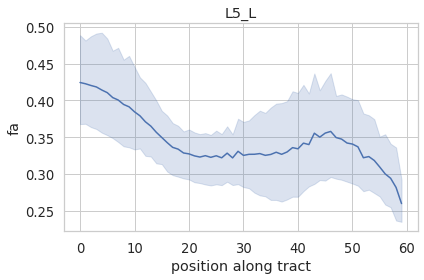

60 distance_map fa L5_R
PAT00002
PAT00003
PAT00009
PAT00010
PAT00012
PAT00013


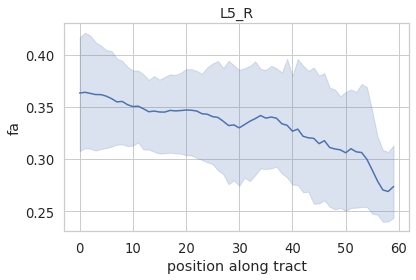

60 distance_map fa S1_L
PAT00002
PAT00003
PAT00009
PAT00010
PAT00012
PAT00013


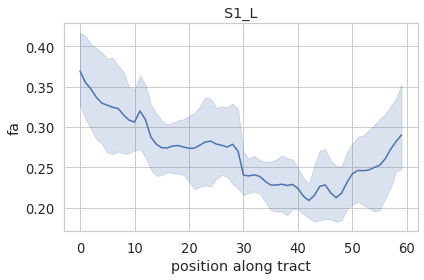

60 distance_map fa S1_R
PAT00002
PAT00003
PAT00009
PAT00010
PAT00012
PAT00013


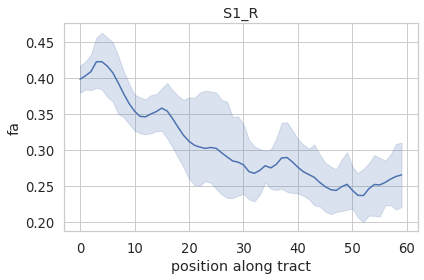

60 distance_map fa S2_L
PAT00002
PAT00003
PAT00009
PAT00010
PAT00012
PAT00013


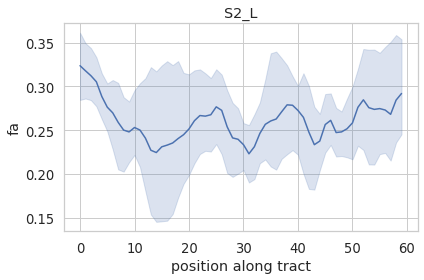

60 distance_map fa S2_R
PAT00002
PAT00003
PAT00009
PAT00010
PAT00012
PAT00013


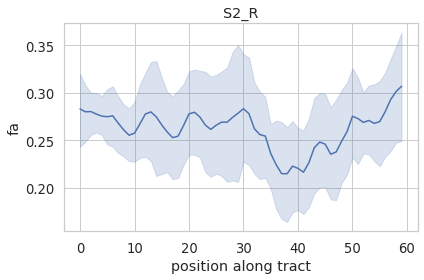

In [35]:
for NR_POINTS in ([60]):
    for ALGORITHM in (['''distance_map''']):
        for PARA in (['''fa''']): 
            for BUNDLE in (['''L5_L''','''L5_R''','''S1_L''','''S1_R''','''S2_L''','''S2_R''']):  
                print(NR_POINTS,ALGORITHM,PARA,BUNDLE)
                if False :#os.path.exists(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+'.npy')) :
                    npvalues=np.load(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+'.npy'))
                else :  
                    #npvalues = np.zeros([len(df),NR_POINTS])
                    #for idx, jdx in df.iterrows():
                    #    SUBJ=df.iloc[idx]['subject_id'] # df.subject_id[0] ou encore jdx['subject_id']
                    listSubj=['PAT00002','PAT00003','PAT00009','PAT00010','PAT00012','PAT00013']
                    npvalues = []# np.zeros([0,NR_POINTS])
                    for idx,SUBJ in enumerate(listSubj):
                        print(SUBJ)
                        TRACTO_TCK=os.path.join(TRACTO_DIR,SUBJ,'tracks_'+BUNDLE+'_prob_5000.tck')
                        SCALAR_IMG=os.path.join(TRACTO_DIR,SUBJ,PARA+'.nii.gz')
                        START_IMG=os.path.join(TRACTO_DIR,SUBJ,'ROI_'+BUNDLE+'.nii.gz')
                        if (os.path.exists(TRACTO_TCK)):
                            scalar_image = nib.load(SCALAR_IMG)
                            beginnings = nib.load(START_IMG)
                            sl_file = nib.streamlines.load(TRACTO_TCK)
                            streamlines = sl_file.streamlines
                            val=list(length(streamlines))
                            #print(np.mean(val),np.std(val))
                            if len(streamlines) > 5 :
                                mean, std = tractometry.evaluate_along_streamlines(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=5,predicted_peaks=None, affine=scalar_image.affine)
                                npvalues.append(mean[1:-1])
                            else :
                                print('oups')
                    #np.save(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)),npvalues)
                sns.set(font_scale=1.2)
                sns.set_style("whitegrid")                    
                %matplotlib inline
                ax = sns.lineplot(x="variable", y="value", data=pd.DataFrame(npvalues).melt())
                ax.set(xlabel='position along tract', ylabel=PARA)
                ax.set_title(BUNDLE)
                plt.tight_layout()
                #plt.savefig(os.path.join(STUDY_PATH,"screenshots",PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+".png"), dpi=300)
                plt.show()
                plt.close()                    

In [23]:
np.array(npvalues).shape

(5, 50)

In [42]:
np.std(npvalues,axis=0)

array([0.07203636, 0.07714415, 0.08627798, 0.09899674, 0.11353317,
       0.12501075, 0.13555548, 0.15096658, 0.16960153, 0.17746674,
       0.16928   , 0.14385467, 0.13136387, 0.13199003, 0.13295256,
       0.13297111, 0.13390898, 0.13699936, 0.13891402, 0.13452835,
       0.1262433 , 0.11968123, 0.11706133, 0.11796389, 0.12156432,
       0.12702194, 0.13327595, 0.13764055, 0.1393262 , 0.13690988,
       0.13071425, 0.11981607, 0.10713438, 0.09507951, 0.08603937,
       0.08045045, 0.0779736 , 0.077841  , 0.07982015, 0.08224145,
       0.08270236, 0.07967841, 0.07371601, 0.06621147, 0.05787219,
       0.04985284, 0.0449948 , 0.04574023, 0.05224854, 0.05590773])

In [86]:
hue = (0.0, 0.0)  # red only
saturation = (0.0, 1.0)  # white to red
img_size = (1000,500)
lut_cmap = actor.colormap_lookup_table(hue_range=hue,
                                       saturation_range=saturation)
for idx, jdx in df.iterrows():
    renderer = window.Renderer()        
    renderer.clear()
    
    SUBJ=df.iloc[idx]['subject_id'] # df.subject_id[0] ou encore jdx['subject_id']
    print(SUBJ)
    for PARA in (['''fa''']): 
        ##ATTENTION j'ai reorienté la FA en LAS afin que ce soit comme les ROIS
        #mri_convert.bin tracto/PAT00003/fa.nii.gz tracto/PAT00003/fa_reorient.nii.gz --out_orientation LAS
        SCALAR_IMG=os.path.join(TRACTO_DIR,SUBJ,PARA+'_reorient.nii.gz')
        scalar_image = nib.load(SCALAR_IMG)
        FA = scalar_image.get_data()
        for BUNDLE in (['''L4L5_L''','''L4L5_R''','''L5S1_L''','''L5S1_R''','''S1S2_L''','''S1S2_R''']):  
            TRACTO_TCK=os.path.join(TRACTO_DIR,SUBJ,'tracks_'+BUNDLE+'_prob_5000.tck')        
            sl_file = nib.streamlines.load(TRACTO_TCK)
            streamlines = sl_file.streamlines
            streamlines = list(transform_streamlines(streamlines, np.linalg.inv(scalar_image.affine)))
            #sl_actor = actor.streamtube(streamlines, FA, linewidth=0.1, opacity=0.2)
            sl_actor = actor.line(streamlines, FA, linewidth=0.1,lookup_colormap=lut_cmap)
            renderer.add(sl_actor)
    
            ROI_IMG=os.path.join(IMAGES_DIR,SUBJ,'ROI_'+BUNDLE+'.nii.gz')
            ROI = nib.load(ROI_IMG)
            mask = ROI.get_data()
            #test1=np.eye(4)
            #test2=scalar_image.affine-ROI.affine
            #test1[1,3]=test2[1,3]
            #test1[1,1]=-1
            #print(test2)
            #print(test1)
            cont_actor = vtk_utils.contour_from_roi_smooth(mask, affine=np.eye(4), color=[.1, .9, .1], opacity=.8,smoothing=1)
            renderer.add(cont_actor)
        
    bar2 = actor.scalar_bar(lut_cmap)
    renderer.add(bar2)
    window.show(renderer, size=img_size, reset_camera=False)
    window.record(renderer, out_path=os.path.join(IMAGES_DIR,SUBJ,SUBJ+'_GlobalView.jpg'), size=img_size)
# window.show(renderer, size=(600, 600), reset_camera=False)

/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0
  import sys
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from versio

PAT00002
PAT00003


In [74]:
print(np.eye(4))

test1=np.eye(4)
test2=scalar_image.affine-ROI.affine
test1[1,3]=test2[1,3]
test1[1,1]=-1
print(test1)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[  1.           0.           0.           0.        ]
 [  0.          -1.           0.         298.83450317]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


In [14]:
import seaborn as sns  # import in function to avoid error if not installed (this is only needed in this function)
from dipy.viz import actor, window
from tractseg.libs import vtk_utils
from scipy.ndimage.morphology import binary_dilation
from dipy.tracking.streamline import transform_streamlines
from scipy.ndimage.morphology import binary_dilation
from dipy.tracking.streamline import set_number_of_points
from dipy.tracking.streamline import length as sl_length
from dipy.tracking.streamline import Streamlines
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from scipy.spatial import cKDTree    
from tractseg.data import dataset_specific_utils
from tractseg.libs import fiber_utils
from tractseg.libs import img_utils

In [15]:
def _add_extra_point_to_last_streamline(sl):
    # Coloring broken as soon as all streamlines have same number of points -> why???
    # Add one number to last streamline to make it have a different number
    sl[-1] = np.append(sl[-1], [sl[-1][-1]], axis=0)
    return sl

In [36]:
# Settings
NR_SEGMENTS = NR_POINTS+4
ANTI_INTERPOL_MULT = 1  # increase number of points to avoid interpolation to blur the colors
algorithm = "distance_map"  # equal_dist | distance_map | cutting_plane
# colors = np.array(sns.color_palette("coolwarm", NR_SEGMENTS))  # colormap blue to red (does not fit to colorbar)
colors = np.array(sns.light_palette("red", NR_SEGMENTS))  # colormap only red, which fits to color_bar
img_size = (1000, 1000)

metrics = mean[1:-1]
print(metrics)
metrics_max = np.asarray(mean[1:-1]).max()
metrics_min = np.asarray(mean[1:-1]).min()
if metrics_max == metrics_min:
    metrics = np.zeros(len(metrics))
else:
    metrics = img_utils.scale_to_range(np.asarray(mean[1:-1]), range=(0, 99))  # range needs to be same as segments in colormap
print(metrics)
orientation = 'axial'

beginnings_img = beginnings.get_data()
for i in range(1):
    beginnings_img = binary_dilation(beginnings_img)

streamlines = list(transform_streamlines(streamlines, np.linalg.inv(beginnings.affine)))
streamlines = fiber_utils.add_to_each_streamline(streamlines, 0.5)
streamlines_new = []
for idx, sl in enumerate(streamlines):
    startpoint = sl[0]
    # Flip streamline if not in right order
    #if beginnings_img[int(startpoint[0]), int(startpoint[1]), int(startpoint[2])] == 0:
    #    sl = sl[::-1, :]
    streamlines_new.append(sl)
streamlines = fiber_utils.add_to_each_streamline(streamlines_new, -0.5)

if algorithm == "distance_map" or algorithm == "equal_dist":
    streamlines = fiber_utils.resample_fibers(streamlines, NR_SEGMENTS * ANTI_INTERPOL_MULT)
elif algorithm == "cutting_plane":
    streamlines = fiber_utils.resample_to_same_distance(streamlines, max_nr_points=NR_SEGMENTS,
                                                        ANTI_INTERPOL_MULT=ANTI_INTERPOL_MULT)

metric = AveragePointwiseEuclideanMetric()
qb = QuickBundles(threshold=100., metric=metric)
clusters = qb.cluster(streamlines)
centroids = Streamlines(clusters.centroids)
_, segment_idxs = cKDTree(centroids.data, 1, copy_data=True).query(streamlines, k=1)

# Add extra point otherwise coloring BUG
streamlines = _add_extra_point_to_last_streamline(streamlines)

renderer = window.Renderer()

FA = scalar_image.get_data()

sl_actor = actor.streamtube(streamlines, FA, linewidth=0.1, opacity=0.2)
renderer.add(sl_actor)

bar = actor.scalar_bar()
renderer.add(bar)
#sl_actor = actor.streamtube(streamlines, colors=colors_all, linewidth=0.1, opacity=0.3)
#renderer.add(sl_actor)

#sl_actor = actor.streamtube(centroids, colors=colors_all, linewidth=1, opacity=1)
lut_cmap = actor.colormap_lookup_table(scale_range=(metrics_min, metrics_max),
                                           hue_range=(0.0, 0.0),
                                           saturation_range=(0.0, 1.0))
sl_actor = actor.line(clusters.centroids,linewidth=10,lookup_colormap=lut_cmap,opacity=1)
renderer.add(sl_actor)

# plot brain mask
mask = beginnings.get_data()
cont_actor = vtk_utils.contour_from_roi_smooth(mask, affine=np.eye(4), color=[.9, .9, .9], opacity=.2,
                                               smoothing=50)
renderer.add(cont_actor)

if True:#show_color_bar:
    lut_cmap = actor.colormap_lookup_table(scale_range=(metrics_min, metrics_max),
                                           hue_range=(0.0, 0.0),
                                           saturation_range=(0.0, 1.0))
    renderer.add(actor.scalar_bar(lut_cmap))

# Use this to interatively get new camera angle
window.show(renderer, size=img_size, reset_camera=False)
print(renderer.get_camera())

window.record(renderer, out_path=output_path, size=img_size)

[0.18228298776679175, 0.14001838239254563, 0.1496765358037641, 0.10405378842853169, 0.14039758987664247, 0.1608005761721907, 0.19664910097335678, 0.1852318647652374, 0.20516870775030557, 0.2145968173657029, 0.24581404072168556, 0.24827364561209067, 0.26505487611471945, 0.24122661891074634, 0.24819721180515775, 0.2499314014703112, 0.2627832990643005, 0.2534364198317011, 0.31103692253593507, 0.3395295560080986, 0.3434855377405953, 0.3224213959548686, 0.3622915575381498, 0.42051201540297833, 0.45976284577502813, 0.49118593822094697, 0.5189315321329505, 0.5316038027427088, 0.5723986473829987, 0.5896000626268377]
[15.95046888  7.33296699  9.30220708  0.          7.41028515 11.57033281
 18.87963399 16.55172737 20.61673118 22.53906671 28.90407305 29.40557187
 32.82716505 27.968725   29.38998747 29.74357844 32.36400398 30.45823085
 42.20263107 48.01210972 48.81871089 44.52385755 52.65314657 64.52395196
 72.52696303 78.93394485 84.59110657 87.17490725 95.49273365 99.        ]


/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: 'ArraySequence.data' property is deprecated.
Please use the 'ArraySequence.get_data()' method instead

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
/home/global/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0
/home/global/anaconda37/lib/pyt

((492966.8662261741, 1096796.5700646557, -331046.9361308012), (1.997610448711911, 528.8124400080627, 13.15009786079461), (-0.8961100608268806, 0.4327383875698664, 0.09861159570900803))


NameError: name 'output_path' is not defined